# Trabajo Fin de Master

---

**Nombre y apellidos:** JOHAN DAVID HERNANDEZ RAMIREZ

**Usuario VIU:** jhernandezr@student.universidadviu.com

---

---
# Inicialización
---

## Importación de Librerias y carga de dataset

In [2]:
# ! pip install pycaret --use-pep517
# ! pip install xgboost
# !pip install shap-selection
# !pip install fitter

In [3]:
# Imports generales

import io
import pandas as pd
import numpy as np
# import holidays
from datetime import timedelta
from numpy import corrcoef, transpose, arange
from io import BytesIO

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as pyo # para exportar en html
import plotly.express as px
import seaborn as sns
from fitter import Fitter
from scipy.stats import beta
from scipy import stats

import warnings

from pycaret import clustering
from pycaret.clustering import *

from scipy.stats import chi2_contingency

from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering
from sklearn.mixture._gaussian_mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier

import boto3

from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score, classification_report  

from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import RFE

import pickle


In [4]:
# cargar el dataset
df_original = pd.read_csv('model_df.csv')

In [5]:
df_original.columns

Index(['CodigoPrestador', 'CausaExterna', 'CodigoDiagnosticoPrincipalSalida',
       'DestinoUsuario', 'EstadoSalida', 'CausaBasicaMuerteUrgencias',
       'TipoUsuario', 'Edad', 'Sexo', 'ZonaResidencia', 'CódigoDepartamento',
       'CódigoMunicipio', 'HoraIngreso', 'Hora Salida',
       'TiempoDeEstancia horas', 'Es festivo (S/N)', 'Es víspera (S/N)',
       'Día Laborable', 'Día de la semana', 'Mes', 'Rango horario ingreso',
       'Rango horario salida', 'Día del mes', 'Es fin de semana',
       'Clasificación estancia', 'Grupo etario', 'ClasificaciónSalida',
       'ClasificaciónSalidaCrítica', 'Nombre asegurador'],
      dtype='object')

In [6]:
df_original.DestinoUsuario.value_counts()

1    1328677
3     363105
2       9973
Name: DestinoUsuario, dtype: int64

# Análisis de features importance

In [1]:
# Dividir en variables independientes (X) y dependiente (y)
X = df_original.drop('DestinoUsuario', axis=1)  # Reemplaza 'DestinoUsuario' por tu variable objetivo
y = df_original['DestinoUsuario']

NameError: name 'df_original' is not defined

## Basada en Importancia (Random Forest Feature Importance)

In [11]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Obtener la importancia de las features
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Mostrar las features más importantes
print(feature_importances)

# Seleccionar las top-N features más importantes (opcional)
top_features = feature_importances.head(10)['Feature'].tolist()
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

                             Feature  Importance
0                    CodigoPrestador    0.147308
2   CodigoDiagnosticoPrincipalSalida    0.114462
25               ClasificaciónSalida    0.093738
13            TiempoDeEstancia horas    0.085614
6                               Edad    0.083878
21                       Día del mes    0.052818
12                       Hora Salida    0.051281
27                 Nombre asegurador    0.049524
11                       HoraIngreso    0.048413
18                               Mes    0.043507
5                        TipoUsuario    0.031310
17                  Día de la semana    0.030981
10                   CódigoMunicipio    0.025547
4         CausaBasicaMuerteUrgencias    0.022571
20              Rango horario salida    0.016787
1                       CausaExterna    0.016551
24                      Grupo etario    0.015695
19             Rango horario ingreso    0.014046
7                               Sexo    0.011726
23            Clasif

## Selección Estadística con Chi-cuadrado

In [10]:
# Usar SelectKBest con Chi-cuadrado
selector = SelectKBest(score_func=chi2, k=10)  # Selecciona las 10 mejores variables
X_new = selector.fit_transform(X, y)

# Ver las variables seleccionadas
selected_features = X.columns[selector.get_support()]
print("Variables seleccionadas:", selected_features)

Variables seleccionadas: Index(['CodigoPrestador', 'CausaExterna', 'CodigoDiagnosticoPrincipalSalida',
       'CausaBasicaMuerteUrgencias', 'Edad', 'CódigoMunicipio',
       'TiempoDeEstancia horas', 'Clasificación estancia',
       'ClasificaciónSalida', 'Nombre asegurador'],
      dtype='object')


## Información Mutua

In [12]:
# Usar SelectKBest con Información Mutua
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

# Ver las variables seleccionadas
selected_features = X.columns[selector.get_support()]
print("Variables seleccionadas:", selected_features)

Variables seleccionadas: Index(['CodigoPrestador', 'CausaExterna', 'CodigoDiagnosticoPrincipalSalida',
       'EstadoSalida', 'CausaBasicaMuerteUrgencias', 'ZonaResidencia',
       'CódigoDepartamento', 'Día Laborable', 'Grupo etario',
       'ClasificaciónSalida'],
      dtype='object')


## Libreria Shap

In [ ]:
# from shap_selection import feature_selection

# feature_names  = df_original.drop('DestinoUsuario', axis=1).columns.to_list()

# # please, use agnostic = True to use with any model...
# # agnostic = False will only work with tree-based models
# feature_order = feature_selection.shap_select(model, X_train, X_test, feature_names, agnostic=False)

# Trainning

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.92
              precision    recall  f1-score   support

           1       0.93      0.96      0.95    265768
           2       0.94      0.23      0.38      2028
           3       0.85      0.75      0.80     72555

    accuracy                           0.92    340351
   macro avg       0.91      0.65      0.71    340351
weighted avg       0.91      0.92      0.91    340351



In [17]:
# # Guardar el modelo entrenado en un archivo
# with open('RandomForestClassifier_all.pkl', 'wb') as file:
#     pickle.dump(model, file)

# print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


In [6]:
selected_features_1 = ['CodigoPrestador', 'CodigoDiagnosticoPrincipalSalida', 'TiempoDeEstancia horas', 'Edad', 'Día del mes',
                    'Nombre asegurador', 'HoraIngreso', 'Mes', 'TipoUsuario', 'Día de la semana', 'CódigoMunicipio', 'CausaExterna',
                    'Grupo etario', 'Rango horario ingreso', 'Sexo']

selected_features_2 = ['CodigoPrestador', 'Edad', 'Día del mes',
                    'Nombre asegurador', 'HoraIngreso', 'Mes', 'TipoUsuario', 'Día de la semana', 'CódigoMunicipio', 'CausaExterna',
                    'Grupo etario', 'Rango horario ingreso', 'Sexo']

selected_features_3 = ['CodigoPrestador', 'Edad', 'Nombre asegurador', 'HoraIngreso', 'TipoUsuario', 'Día de la semana', 'CódigoMunicipio', 'CausaExterna', 'Sexo']

In [8]:
# Dividir en variables independientes (X) y dependiente (y)
X = df_original[selected_features_1]
y = df_original['DestinoUsuario']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.90
              precision    recall  f1-score   support

           1       0.92      0.96      0.94    265768
           2       0.87      0.20      0.33      2028
           3       0.83      0.73      0.77     72555

    accuracy                           0.90    340351
   macro avg       0.87      0.63      0.68    340351
weighted avg       0.90      0.90      0.90    340351



In [10]:
s3 = boto3.client('s3', region_name='us-east-1')

# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(model, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/RandomForestClassifier_SF_1.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/RandomForestClassifier_SF_1.pkl


In [6]:
# Dividir en variables independientes (X) y dependiente (y)
X = df_original[selected_features_2]
y = df_original['DestinoUsuario']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model_2 = RandomForestClassifier(random_state=42)
model_2.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model_2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.86
              precision    recall  f1-score   support

           1       0.90      0.93      0.92    265768
           2       0.62      0.17      0.27      2028
           3       0.72      0.63      0.67     72555

    accuracy                           0.86    340351
   macro avg       0.75      0.58      0.62    340351
weighted avg       0.86      0.86      0.86    340351



In [7]:
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(model_2, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/RandomForestClassifier_SF_2.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/RandomForestClassifier_SF_2.pkl


In [8]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


In [5]:
# Dividir en variables independientes (X) y dependiente (y)
X = df_original[selected_features_3]
y = df_original['DestinoUsuario']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.83
              precision    recall  f1-score   support

           1       0.88      0.91      0.90    265768
           2       0.24      0.06      0.10      2028
           3       0.64      0.57      0.60     72555

    accuracy                           0.83    340351
   macro avg       0.59      0.52      0.53    340351
weighted avg       0.83      0.83      0.83    340351



## Balanceo de clases SMOTE

In [9]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE(random_state=123).fit_resample(X, y)

In [10]:
y_resampled.value_counts()

1    1328677
2    1328677
3    1328677
Name: DestinoUsuario, dtype: int64

In [11]:
ros_dataset = X_resampled
ros_dataset['default'] = y_resampled
ros_dataset.shape

(3986031, 14)

### Modelo 4 Overfiting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
model_4 = RandomForestClassifier(random_state=42)
model_4.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model_4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

### Modelo 5 Overfiting

In [23]:
from lightgbm import LGBMClassifier

model_5 = LGBMClassifier(random_state=42)
model_5.fit(X_resampled, y_resampled)

# Hacer predicciones y evaluar el modelo
y_pred = model_5.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 1.00
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    265452
           2       1.00      1.00      1.00    266149
           3       1.00      1.00      1.00    265606

    accuracy                           1.00    797207
   macro avg       1.00      1.00      1.00    797207
weighted avg       1.00      1.00      1.00    797207



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 318882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 318882, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

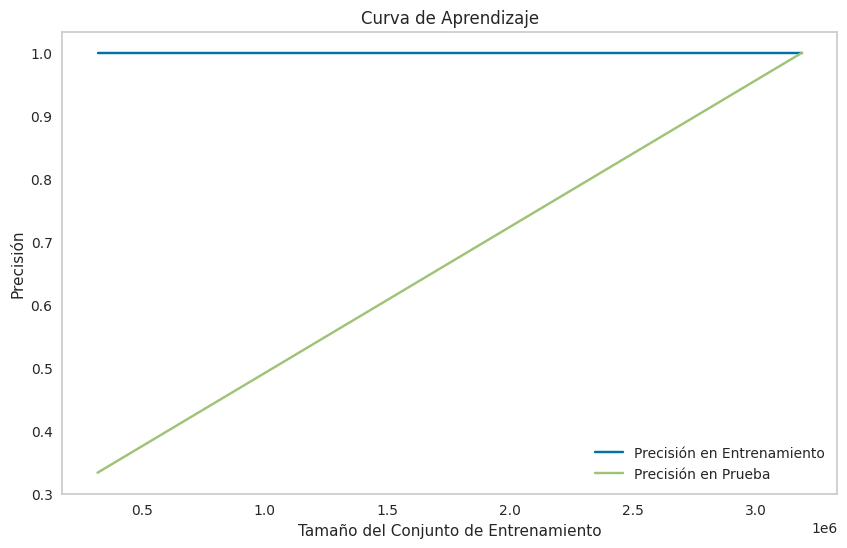

In [24]:
# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_5, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 2), random_state=42
)

# Promediar los puntajes
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Precisión en Entrenamiento')
plt.plot(train_sizes, test_scores_mean, label='Precisión en Prueba')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

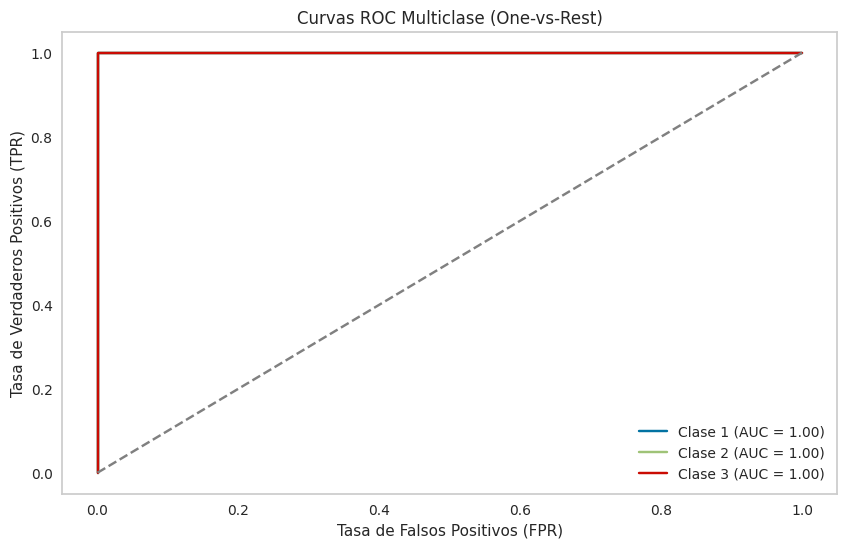

In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Binarizar las clases
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_proba = model_5.predict_proba(X_test)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(10, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Clase {class_label} (AUC = {auc_scores[class_label]:.2f})')

# Línea aleatoria
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Etiquetas
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Multiclase (One-vs-Rest)')
plt.legend()
plt.grid()
plt.show()


### Modelo 6 Overfiting

In [29]:
import warnings
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

# Configurar el modelo con profundidad limitada
model_6 = LGBMClassifier(random_state=42, max_depth=3, num_leaves=7)

# Entrenar el modelo
model_6.fit(X_resampled, y_resampled)

# Hacer predicciones y evaluar el modelo
y_pred = model_6.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 3986031, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 318882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 318882, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

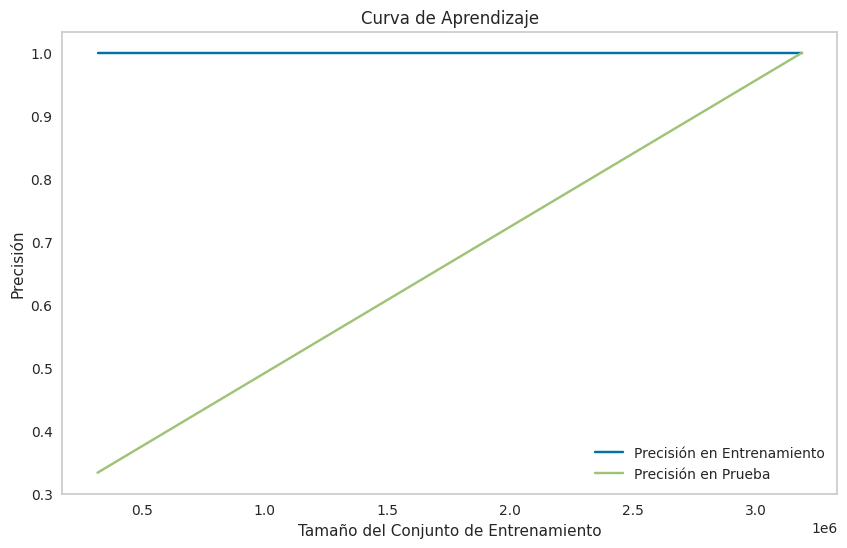

In [30]:
# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_6, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 2), random_state=42
)

# Promediar los puntajes
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Precisión en Entrenamiento')
plt.plot(train_sizes, test_scores_mean, label='Precisión en Prueba')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid()
plt.show()

## Balanceo de clases ADASYN 2

In [56]:
# Dividir en variables independientes (X) y dependiente (y)
X = df_original[selected_features_2]
y = df_original['DestinoUsuario']

In [57]:
y.value_counts()

1    1328677
3     363105
2       9973
Name: DestinoUsuario, dtype: int64

### 1

In [11]:
from imblearn.over_sampling import ADASYN
import numpy as np

# Tamaño deseado para la clase minoritaria
target_size = 200000

# Distribución actual
class_counts = y.value_counts()

# Calcular el nuevo ratio
sampling_strategy = {
    1: class_counts[1],  # Clase mayoritaria no cambia
    3: class_counts[3],  # Clase intermedia no cambia
    2: target_size       # Clase minoritaria ajustada
}

# Aplicar ADASYN con el sampling_strategy ajustado
adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=123)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Verificar nueva distribución
print("Distribución después de ADASYN:")
print(np.bincount(y_resampled))

Distribución después de ADASYN:
[      0 1328677  199148  363105]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.87
              precision    recall  f1-score   support

           1       0.89      0.93      0.91    265730
           2       0.94      0.94      0.94     39830
           3       0.72      0.62      0.66     72626

    accuracy                           0.87    378186
   macro avg       0.85      0.83      0.84    378186
weighted avg       0.87      0.87      0.87    378186



In [13]:
# predictions = model.predict(X_test)
prob = model.predict_proba(X_test)

In [17]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Overall metrics
print("Overall Accuracy:",accuracy)
print("Overall Precision:",precision_score(y_test, y_pred, average='macro'))
print("Overall Recall:",recall_score(y_test, y_pred, average='macro'))
print('Average AUC:', roc_auc_score(y_test,prob, multi_class='ovr'))

# # Confusion matrix
# plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
# plt.colorbar()
# tick_marks = np.arange(len(penguin_classes))
# plt.xticks(tick_marks, penguin_classes, rotation=45)
# plt.yticks(tick_marks, penguin_classes)
# plt.xlabel("Actual Species")
# plt.ylabel("Predicted Species")
# plt.show()

Overall Accuracy: 0.8700216295685191
Overall Precision: 0.8513718309621282
Overall Recall: 0.8289386379633163
Average AUC: 0.9519688633961382


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

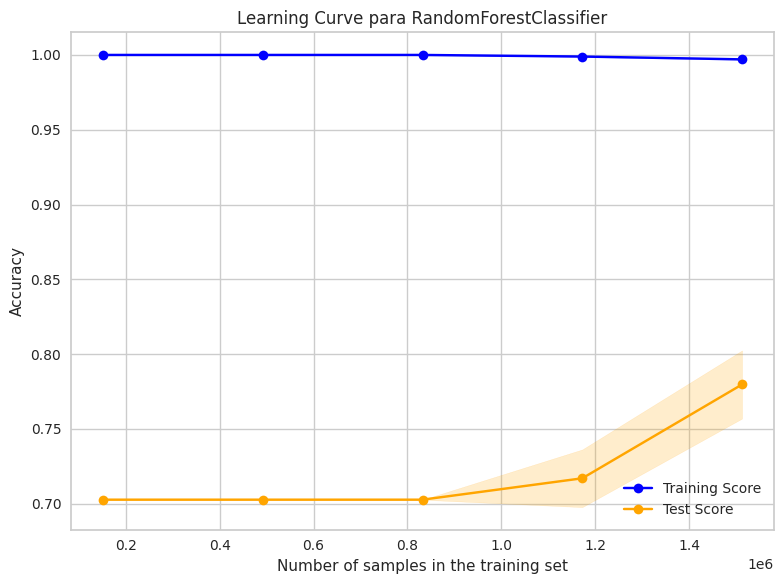

In [18]:
# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para RandomForestClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

In [20]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9970
Precision (macro): 0.9952
Recall (macro): 0.9959
F1 Score (macro): 0.9956
AUC (One-vs-Rest): 0.9999
              precision    recall  f1-score   support

           1       1.00      1.00      1.00   1062947
           2       0.99      1.00      0.99    159318
           3       1.00      0.99      0.99    290479

    accuracy                           1.00   1512744
   macro avg       1.00      1.00      1.00   1512744
weighted avg       1.00      1.00      1.00   1512744

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8700
Precision (macro): 0.8514
Recall (macro): 0.8289
F1 Score (macro): 0.8387
AUC (One-vs-Rest): 0.9520
              precision    recall  f1-score   support

           1       0.89      0.93      0.91    265730
           2       0.94      0.94      0.94     39830
           3       0.72      0.62      0.66     72626

    accuracy                       

In [64]:
from imblearn.over_sampling import ADASYN
import numpy as np

# Tamaño deseado para la clase minoritaria
target_size = 150000

# Distribución actual
class_counts = y.value_counts()

# Calcular el nuevo ratio
sampling_strategy = {
    1: class_counts[1],  # Clase mayoritaria no cambia
    3: class_counts[3],  # Clase intermedia no cambia
    2: target_size       # Clase minoritaria ajustada
}

# Aplicar ADASYN con el sampling_strategy ajustado
adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=123)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Verificar nueva distribución
print("Distribución después de ADASYN:")
print(np.bincount(y_resampled))

Distribución después de ADASYN:
[      0 1328677  149851  363105]


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.86
              precision    recall  f1-score   support

           1       0.89      0.93      0.91    398568
           2       0.89      0.65      0.75     16131
           3       0.71      0.61      0.66    108866

    accuracy                           0.86    523565
   macro avg       0.83      0.73      0.77    523565
weighted avg       0.85      0.86      0.85    523565



In [65]:
from sklearn.model_selection import train_test_split, cross_val_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Configurar el modelo de Random Forest con hiperparámetros para combatir el sobreajuste
model = RandomForestClassifier(
    n_estimators=100,               # Número de árboles
    max_depth=10,                   # Profundidad máxima de los árboles
    min_samples_split=10,           # Muestras mínimas para dividir un nodo
    # min_samples_leaf=5,             # Muestras mínimas por hoja
    # max_features='sqrt',            # Número máximo de características consideradas para cada división
    random_state=42
    # class_weight='balanced'         # Manejo del desbalanceo de clases
)

# Validación cruzada (5 folds)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Promedio de Accuracy en CV: {cv_scores.mean():.2f} (std: {cv_scores.std():.2f})")

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Promedio de Accuracy en CV: 0.77 (std: 0.00)
Precisión del modelo en el conjunto de prueba: 0.77
              precision    recall  f1-score   support

           1       0.78      0.96      0.86    265523
           2       0.87      0.07      0.13     29962
           3       0.68      0.35      0.46     72842

    accuracy                           0.77    368327
   macro avg       0.77      0.46      0.48    368327
weighted avg       0.76      0.77      0.72    368327



In [66]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear el modelo de LightGBM con hiperparámetros ajustados para evitar sobreajuste
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',          # Tipo de boosting
    n_estimators=500,              # Número de árboles (controlar el sobreajuste)
    max_depth=10,                  # Profundidad máxima de los árboles
    learning_rate=0.05,            # Tasa de aprendizaje
    num_leaves=31,                 # Número de hojas por árbol (controlar la complejidad)
    min_child_samples=20,          # Mínimo de datos en un nodo hoja
    subsample=0.8,                 # Tasa de muestreo de datos
    colsample_bytree=0.8,          # Fracción de características utilizadas
    # class_weight='balanced',       # Manejo automático de desbalanceo
    random_state=42                # Semilla para reproducibilidad
)

# Validación cruzada (5 folds)
cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Promedio de Accuracy en CV: {cv_scores.mean():.2f} (std: {cv_scores.std():.2f})")

# Entrenar el modelo
lgb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = lgb_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 1178644, number of used features: 13
[LightGBM] [Info] Start training from score -0.326268
[LightGBM] [Info] Start training from score -2.508699
[LightGBM] [Info] Start training from score -1.624478
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 1178645

### Mejor modelo 

In [67]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN(random_state=123).fit_resample(X, y)

In [69]:
y_resampled.value_counts()

3    1336056
2    1329134
1    1328677
Name: DestinoUsuario, dtype: int64

In [70]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear el modelo de LightGBM con hiperparámetros ajustados para evitar sobreajuste
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',          # Tipo de boosting
    n_estimators=500,              # Número de árboles (controlar el sobreajuste)
    max_depth=10,                  # Profundidad máxima de los árboles
    learning_rate=0.05,            # Tasa de aprendizaje
    num_leaves=31,                 # Número de hojas por árbol (controlar la complejidad)
    min_child_samples=20,          # Mínimo de datos en un nodo hoja
    subsample=0.8,                 # Tasa de muestreo de datos
    colsample_bytree=0.8,          # Fracción de características utilizadas
    # class_weight='balanced',       # Manejo automático de desbalanceo
    random_state=42                # Semilla para reproducibilidad
)

# Validación cruzada (5 folds)
cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Promedio de Accuracy en CV: {cv_scores.mean():.2f} (std: {cv_scores.std():.2f})")

# Entrenar el modelo
lgb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = lgb_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 754
[LightGBM] [Info] Number of data points in the train set: 2556074, number of used features: 13
[LightGBM] [Info] Start training from score -1.100285
[LightGBM] [Info] Start training from score -1.100464
[LightGBM] [Info] Start training from score -1.095097
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 2556074

In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = lgb_model.predict(X_train)
y_train_prob = lgb_model.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = lgb_model.predict(X_test)
y_test_prob = lgb_model.predict_proba(X_test)

In [77]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.7955
Precision (macro): 0.7978
Recall (macro): 0.7956
F1 Score (macro): 0.7943
AUC (One-vs-Rest): 0.9330
              precision    recall  f1-score   support

           1       0.81      0.70      0.75   1063225
           2       0.83      0.85      0.84   1062528
           3       0.75      0.85      0.80   1063071

    accuracy                           0.80   3188824
   macro avg       0.80      0.80      0.79   3188824
weighted avg       0.80      0.80      0.79   3188824

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.7948
Precision (macro): 0.7971
Recall (macro): 0.7947
F1 Score (macro): 0.7934
AUC (One-vs-Rest): 0.9325
              precision    recall  f1-score   support

           1       0.81      0.69      0.75    265452
           2       0.83      0.85      0.84    266149
           3       0.75      0.85      0.80    265606

    accuracy                       

In [81]:
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(lgb_model, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/LGBMClassifier_SF2_BM1.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/LGBMClassifier_SF2_BM1.pkl


In [82]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Desactivar warnings
warnings.filterwarnings("ignore")

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    lgb_model, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para RandomForestClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()


## Mejor modelo 2

In [7]:
# Dividir en variables independientes (X) y dependiente (y)
X = df_original[selected_features_2]
y = df_original['DestinoUsuario']

In [8]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE(random_state=123).fit_resample(X, y)

In [75]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear el modelo de LightGBM con hiperparámetros ajustados para evitar sobreajuste
lgb_model_2 = lgb.LGBMClassifier(
    boosting_type='gbdt',          # Tipo de boosting
    n_estimators=500,              # Número de árboles (controlar el sobreajuste)
    max_depth=10,                  # Profundidad máxima de los árboles
    learning_rate=0.05,            # Tasa de aprendizaje
    num_leaves=31,                 # Número de hojas por árbol (controlar la complejidad)
    min_child_samples=20,          # Mínimo de datos en un nodo hoja
    subsample=0.8,                 # Tasa de muestreo de datos
    colsample_bytree=0.8,          # Fracción de características utilizadas
    # class_weight='balanced',       # Manejo automático de desbalanceo
    random_state=42                # Semilla para reproducibilidad
)

# Validación cruzada (5 folds)
cv_scores = cross_val_score(lgb_model_2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Promedio de Accuracy en CV: {cv_scores.mean():.2f} (std: {cv_scores.std():.2f})")

# Entrenar el modelo
lgb_model_2.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = lgb_model_2.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 2551059, number of used features: 13
[LightGBM] [Info] Start training from score -1.098345
[LightGBM] [Info] Start training from score -1.099002
[LightGBM] [Info] Start training from score -1.098490
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 2551059

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = lgb_model_2.predict(X_train)
y_train_prob = lgb_model_2.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = lgb_model_2.predict(X_test)
y_test_prob = lgb_model_2.predict_proba(X_test)

In [79]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.7994
Precision (macro): 0.7995
Recall (macro): 0.7994
F1 Score (macro): 0.7983
AUC (One-vs-Rest): 0.9341
              precision    recall  f1-score   support

           1       0.80      0.72      0.76   1063225
           2       0.81      0.87      0.84   1062528
           3       0.78      0.81      0.80   1063071

    accuracy                           0.80   3188824
   macro avg       0.80      0.80      0.80   3188824
weighted avg       0.80      0.80      0.80   3188824

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.7984
Precision (macro): 0.7984
Recall (macro): 0.7983
F1 Score (macro): 0.7972
AUC (One-vs-Rest): 0.9334
              precision    recall  f1-score   support

           1       0.80      0.72      0.76    265452
           2       0.81      0.86      0.84    266149
           3       0.78      0.81      0.80    265606

    accuracy                       

In [83]:
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(lgb_model_2, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/LGBMClassifier_SF2_BM2.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/LGBMClassifier_SF2_BM2.pkl


In [84]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


In [13]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

lgb_model_2_1 = lgb.LGBMClassifier(
    boosting_type='gbdt',          # Tipo de boosting
    n_estimators=500,              # Número de árboles (controlar el sobreajuste)
    max_depth=10,                  # Profundidad máxima de los árboles
    learning_rate=0.05,            # Tasa de aprendizaje
    num_leaves=31,                 # Número de hojas por árbol (controlar la complejidad)
    min_child_samples=20,          # Mínimo de datos en un nodo hoja
    subsample=0.8,                 # Tasa de muestreo de datos
    # colsample_bytree=0.8,          # Fracción de características utilizadas
    # class_weight='balanced',       # Manejo automático de desbalanceo
    random_state=42                # Semilla para reproducibilidad
)


# Validación cruzada (5 folds)
cv_scores = cross_val_score(lgb_model_2_1, X_train, y_train, cv=5, scoring='accuracy')
print(f"Promedio de Accuracy en CV: {cv_scores.mean():.2f} (std: {cv_scores.std():.2f})")

# Entrenar el modelo
lgb_model_2_1.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = lgb_model_2_1.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 2551059, number of used features: 13
[LightGBM] [Info] Start training from score -1.098345
[LightGBM] [Info] Start training from score -1.099002
[LightGBM] [Info] Start training from score -1.098490
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 2551059

In [16]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

lgb_model_2_2 = lgb.LGBMClassifier(
    boosting_type='gbdt',          # Tipo de boosting
    n_estimators=1000,              # Número de árboles (controlar el sobreajuste)
    max_depth=10,                  # Profundidad máxima de los árboles
    learning_rate=0.05,            # Tasa de aprendizaje
    num_leaves=31,                 # Número de hojas por árbol (controlar la complejidad)
    min_child_samples=20,          # Mínimo de datos en un nodo hoja
    # subsample=0.8,                 # Tasa de muestreo de datos
    # colsample_bytree=0.8,          # Fracción de características utilizadas
    # class_weight='balanced',       # Manejo automático de desbalanceo
    random_state=42                # Semilla para reproducibilidad
)


# Validación cruzada (5 folds)
cv_scores = cross_val_score(lgb_model_2_2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Promedio de Accuracy en CV: {cv_scores.mean():.2f} (std: {cv_scores.std():.2f})")

# Entrenar el modelo
lgb_model_2_2.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = lgb_model_2_2.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 2551059, number of used features: 13
[LightGBM] [Info] Start training from score -1.098345
[LightGBM] [Info] Start training from score -1.099002
[LightGBM] [Info] Start training from score -1.098490
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 2551059

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = lgb_model_2_2.predict(X_train)
y_train_prob = lgb_model_2_2.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = lgb_model_2_2.predict(X_test)
y_test_prob = lgb_model_2_2.predict_proba(X_test)

In [18]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.8184
Precision (macro): 0.8184
Recall (macro): 0.8184
F1 Score (macro): 0.8171
AUC (One-vs-Rest): 0.9433
              precision    recall  f1-score   support

           1       0.82      0.73      0.78   1063225
           2       0.84      0.90      0.87   1062528
           3       0.79      0.82      0.81   1063071

    accuracy                           0.82   3188824
   macro avg       0.82      0.82      0.82   3188824
weighted avg       0.82      0.82      0.82   3188824

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8169
Precision (macro): 0.8168
Recall (macro): 0.8168
F1 Score (macro): 0.8155
AUC (One-vs-Rest): 0.9423
              precision    recall  f1-score   support

           1       0.82      0.73      0.77    265452
           2       0.84      0.90      0.87    266149
           3       0.79      0.82      0.81    265606

    accuracy                       

In [23]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear el modelo de LightGBM
lgb_model_early_stop = lgb.LGBMClassifier(
    boosting_type='gbdt',          # Tipo de boosting
    n_estimators=1500,              # Número de árboles (controlar el sobreajuste)
    max_depth=10,                  # Profundidad máxima de los árboles
    learning_rate=0.05,            # Tasa de aprendizaje
    num_leaves=31,                 # Número de hojas por árbol (controlar la complejidad)
    min_child_samples=20,          # Mínimo de datos en un nodo hoja
    # subsample=0.8,                 # Tasa de muestreo de datos
    # colsample_bytree=0.8,          # Fracción de características utilizadas
    # class_weight='balanced',       # Manejo automático de desbalanceo
    random_state=42                # Semilla para reproducibilidad
)

# Configurar callbacks para early stopping
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
]

# Entrenar el modelo con early stopping
lgb_model_early_stop.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],       # Conjunto de validación
    eval_metric='multi_logloss',      # Métrica de evaluación
    callbacks=callbacks               # Early stopping con callbacks
)

# Hacer predicciones en el conjunto de prueba
y_pred = lgb_model_early_stop.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 3188824, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098345
[LightGBM] [Info] Start training from score -1.099001
[LightGBM] [Info] Start training from score -1.098490
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1500]	valid_0's multi_logloss: 0.432185
Precisión del modelo en el conjunto de prueba: 0.83
              precision    recall  f1-score   support

           1       0.83      0.74      0.78    265452
           2 

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = lgb_model_early_stop.predict(X_train)
y_train_prob = lgb_model_early_stop.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = lgb_model_early_stop.predict(X_test)
y_test_prob = lgb_model_early_stop.predict_proba(X_test)

In [25]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.8303
Precision (macro): 0.8303
Recall (macro): 0.8304
F1 Score (macro): 0.8290
AUC (One-vs-Rest): 0.9490
              precision    recall  f1-score   support

           1       0.84      0.74      0.79   1063225
           2       0.85      0.92      0.88   1062528
           3       0.80      0.83      0.82   1063071

    accuracy                           0.83   3188824
   macro avg       0.83      0.83      0.83   3188824
weighted avg       0.83      0.83      0.83   3188824

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8282
Precision (macro): 0.8280
Recall (macro): 0.8281
F1 Score (macro): 0.8267
AUC (One-vs-Rest): 0.9477
              precision    recall  f1-score   support

           1       0.83      0.74      0.78    265452
           2       0.85      0.92      0.88    266149
           3       0.80      0.83      0.81    265606

    accuracy                       

In [28]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear el modelo de LightGBM
lgb_model_early_stop_2 = lgb.LGBMClassifier(
    boosting_type='gbdt',          # Tipo de boosting
    n_estimators=2500,              # Número de árboles (controlar el sobreajuste)
    max_depth=10,                  # Profundidad máxima de los árboles
    learning_rate=0.05,            # Tasa de aprendizaje
    num_leaves=31,                 # Número de hojas por árbol (controlar la complejidad)
    min_child_samples=20,          # Mínimo de datos en un nodo hoja
    # subsample=0.8,                 # Tasa de muestreo de datos
    # colsample_bytree=0.8,          # Fracción de características utilizadas
    # class_weight='balanced',       # Manejo automático de desbalanceo
    random_state=42                # Semilla para reproducibilidad
)

# Configurar callbacks para early stopping
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
]

# Entrenar el modelo con early stopping
lgb_model_early_stop_2.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],       # Conjunto de validación
    eval_metric='multi_logloss',      # Métrica de evaluación
    callbacks=callbacks               # Early stopping con callbacks
)

# Hacer predicciones en el conjunto de prueba
y_pred = lgb_model_early_stop_2.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 3188824, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098345
[LightGBM] [Info] Start training from score -1.099001
[LightGBM] [Info] Start training from score -1.098490
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's multi_logloss: 0.401062
Precisión del modelo en el conjunto de prueba: 0.84
              precision    recall  f1-score   support

           1       0.85      0.75      0.80    265452
           2 

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = lgb_model_early_stop_2.predict(X_train)
y_train_prob = lgb_model_early_stop_2.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = lgb_model_early_stop_2.predict(X_test)
y_test_prob = lgb_model_early_stop_2.predict_proba(X_test)

In [30]:
# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.8457
Precision (macro): 0.8455
Recall (macro): 0.8458
F1 Score (macro): 0.8443
AUC (One-vs-Rest): 0.9563
              precision    recall  f1-score   support

           1       0.85      0.76      0.80   1063225
           2       0.87      0.94      0.91   1062528
           3       0.81      0.84      0.83   1063071

    accuracy                           0.85   3188824
   macro avg       0.85      0.85      0.84   3188824
weighted avg       0.85      0.85      0.84   3188824

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8428
Precision (macro): 0.8425
Recall (macro): 0.8427
F1 Score (macro): 0.8412
AUC (One-vs-Rest): 0.9544
              precision    recall  f1-score   support

           1       0.85      0.75      0.80    265452
           2       0.87      0.94      0.90    266149
           3       0.81      0.83      0.82    265606

    accuracy                       

In [33]:
# Serializar el modelo en un objeto BytesIO
model_buffer = BytesIO()
pickle.dump(lgb_model_early_stop_2, model_buffer)
model_buffer.seek(0)  # Asegurar que el puntero esté al inicio del buffer

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Subir el modelo directamente a S3
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/lgb_model_early_stop_2.pkl'

try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer)
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")

Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/lgb_model_early_stop_2.pkl


In [34]:
# Reiniciar el buffer
model_buffer.truncate(0)  # Eliminar todo el contenido del buffer
model_buffer.seek(0)      # Colocar el puntero al inicio del buffer

print("Buffer reiniciado exitosamente.")

Buffer reiniciado exitosamente.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 318882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 318882, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

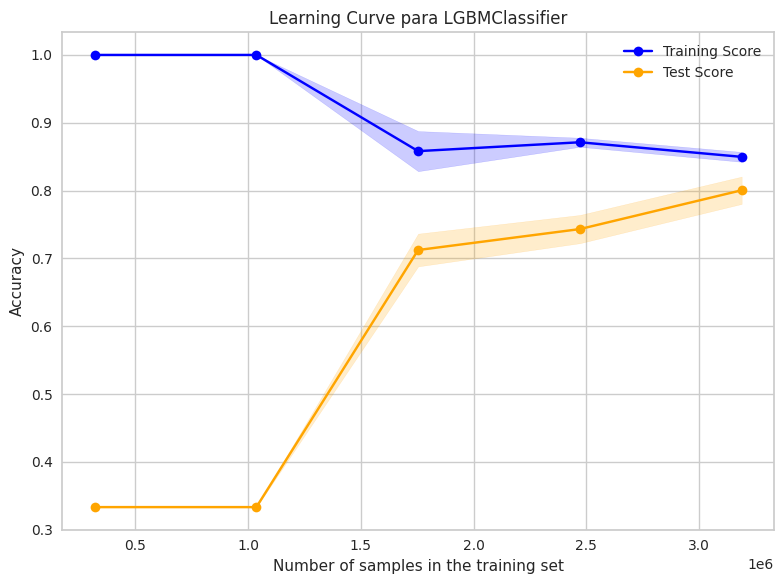

In [36]:
import matplotlib.pyplot as plt
import matplotlib

# Configurar fuente específica
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Suprimir advertencias generales
warnings.filterwarnings("ignore")

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    lgb_model_early_stop_2, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para LGBMClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

In [31]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

lgb_model_2_2 = lgb.LGBMClassifier(
    boosting_type='gbdt',          # Tipo de boosting
    n_estimators=3000,              # Número de árboles (controlar el sobreajuste)
    max_depth=10,                  # Profundidad máxima de los árboles
    learning_rate=0.05,            # Tasa de aprendizaje
    num_leaves=31,                 # Número de hojas por árbol (controlar la complejidad)
    min_child_samples=20,          # Mínimo de datos en un nodo hoja
    # subsample=0.8,                 # Tasa de muestreo de datos
    # colsample_bytree=0.8,          # Fracción de características utilizadas
    # class_weight='balanced',       # Manejo automático de desbalanceo
    random_state=42                # Semilla para reproducibilidad
)


# Validación cruzada (5 folds)
cv_scores = cross_val_score(lgb_model_2_2, X_train, y_train, cv=5, scoring='accuracy')
print(f"Promedio de Accuracy en CV: {cv_scores.mean():.2f} (std: {cv_scores.std():.2f})")

# Entrenar el modelo
lgb_model_2_2.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = lgb_model_2_2.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 2551059, number of used features: 13
[LightGBM] [Info] Start training from score -1.098345
[LightGBM] [Info] Start training from score -1.099002
[LightGBM] [Info] Start training from score -1.098490
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 2551059, number of used features: 13
[LightGBM] [Info] Start training f

In [9]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

# Modelo LightGBM
lgb_model = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

# Ensamblaje con VotingClassifier (Hard Voting)
ensemble_model = VotingClassifier(
    estimators=[
        ('Random Forest', rf_model),
        ('LightGBM', lgb_model)
    ],
    voting='soft'  # Cambia a 'hard' si prefieres predicciones por mayoría simple
)

# Entrenar el modelo ensamblado
ensemble_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = ensemble_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo ensamblado en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 3188824, number of used features: 13
[LightGBM] [Info] Start training from score -1.098345
[LightGBM] [Info] Start training from score -1.099001
[LightGBM] [Info] Start training from score -1.098490
Precisión del modelo ensamblado en el conjunto de prueba: 0.77
              precision    recall  f1-score   support

           1       0.78      0.69      0.73    265452
           2       0.78      0.83      0.81    266149
           3       0.76      0.80      0.78    265606

    accuracy                           0.77    797207
   macro avg       0.77      0.77      0.77    797207
weighted avg   

### 2

In [21]:
from imblearn.over_sampling import ADASYN
import numpy as np

# Tamaño deseado para la clase minoritaria
target_size = 100000

# Distribución actual
class_counts = y.value_counts()

# Calcular el nuevo ratio
sampling_strategy = {
    1: class_counts[1],  # Clase mayoritaria no cambia
    3: class_counts[3],  # Clase intermedia no cambia
    2: target_size       # Clase minoritaria ajustada
}

# Aplicar ADASYN con el sampling_strategy ajustado
adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=123)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Verificar nueva distribución
print("Distribución después de ADASYN:")
print(np.bincount(y_resampled))

Distribución después de ADASYN:
[      0 1328677   96895  363105]


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.86
              precision    recall  f1-score   support

           1       0.89      0.93      0.91    265572
           2       0.92      0.83      0.87     19384
           3       0.72      0.62      0.67     72780

    accuracy                           0.86    357736
   macro avg       0.84      0.80      0.82    357736
weighted avg       0.86      0.86      0.86    357736



###  3

In [23]:
from imblearn.over_sampling import ADASYN
import numpy as np

# Tamaño deseado para la clase minoritaria
target_size = 100000
target_size_2 = 500000

# Distribución actual
class_counts = y.value_counts()

# Calcular el nuevo ratio
sampling_strategy = {
    1: class_counts[1],  # Clase mayoritaria no cambia
    3: target_size_2,  # Clase intermedia no cambia
    2: target_size       # Clase minoritaria ajustada
}

# Aplicar ADASYN con el sampling_strategy ajustado
adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=123)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Verificar nueva distribución
print("Distribución después de ADASYN:")
print(np.bincount(y_resampled))

Distribución después de ADASYN:
[      0 1328677   96895  522763]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
model_A = RandomForestClassifier(random_state=42)
model_A.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model_A.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.85
              precision    recall  f1-score   support

           1       0.89      0.90      0.90    265706
           2       0.90      0.83      0.86     19378
           3       0.75      0.74      0.75    104583

    accuracy                           0.85    389667
   macro avg       0.85      0.82      0.83    389667
weighted avg       0.85      0.85      0.85    389667



In [26]:
# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = model_A.predict(X_train)
y_train_prob = model.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = model_A.predict(X_test)
y_test_prob = model_A.predict_proba(X_test)

In [27]:
# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9969
Precision (macro): 0.9936
Recall (macro): 0.9952
F1 Score (macro): 0.9944
AUC (One-vs-Rest): 0.9879
              precision    recall  f1-score   support

           1       1.00      1.00      1.00   1062971
           2       0.99      0.99      0.99     77517
           3       1.00      0.99      1.00    418180

    accuracy                           1.00   1558668
   macro avg       0.99      1.00      0.99   1558668
weighted avg       1.00      1.00      1.00   1558668

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8549
Precision (macro): 0.8461
Recall (macro): 0.8224
F1 Score (macro): 0.8337
AUC (One-vs-Rest): 0.9501
              precision    recall  f1-score   support

           1       0.89      0.90      0.90    265706
           2       0.90      0.83      0.86     19378
           3       0.75      0.74      0.75    104583

    accuracy                       

### 4

In [30]:
from imblearn.over_sampling import ADASYN
import numpy as np

# Tamaño deseado para la clase minoritaria
target_size = 150000
target_size_2 = 800000

# Distribución actual
class_counts = y.value_counts()

# Calcular el nuevo ratio
sampling_strategy = {
    1: class_counts[1],  # Clase mayoritaria no cambia
    3: target_size_2,  # Clase intermedia no cambia
    2: target_size       # Clase minoritaria ajustada
}

# Aplicar ADASYN con el sampling_strategy ajustado
adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=123)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Verificar nueva distribución
print("Distribución después de ADASYN:")
print(np.bincount(y_resampled))

Distribución después de ADASYN:
[      0 1328677  149851  852020]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
model_A4 = RandomForestClassifier(random_state=42)
model_A4.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model_A4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.87
              precision    recall  f1-score   support

           1       0.91      0.87      0.89    265784
           2       0.92      0.89      0.90     30253
           3       0.81      0.87      0.84    170073

    accuracy                           0.87    466110
   macro avg       0.88      0.87      0.87    466110
weighted avg       0.87      0.87      0.87    466110



In [33]:
# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = model_A4.predict(X_train)
y_train_prob = model_A4.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = model_A4.predict(X_test)
y_test_prob = model_A4.predict_proba(X_test)

In [34]:
# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 0.9967
Precision (macro): 0.9940
Recall (macro): 0.9961
F1 Score (macro): 0.9950
AUC (One-vs-Rest): 0.9999
              precision    recall  f1-score   support

           1       1.00      1.00      1.00   1062893
           2       0.99      1.00      0.99    119598
           3       1.00      1.00      1.00    681947

    accuracy                           1.00   1864438
   macro avg       0.99      1.00      1.00   1864438
weighted avg       1.00      1.00      1.00   1864438

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 0.8684
Precision (macro): 0.8771
Recall (macro): 0.8740
F1 Score (macro): 0.8749
AUC (One-vs-Rest): 0.9632
              precision    recall  f1-score   support

           1       0.91      0.87      0.89    265784
           2       0.92      0.89      0.90     30253
           3       0.81      0.87      0.84    170073

    accuracy                       

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

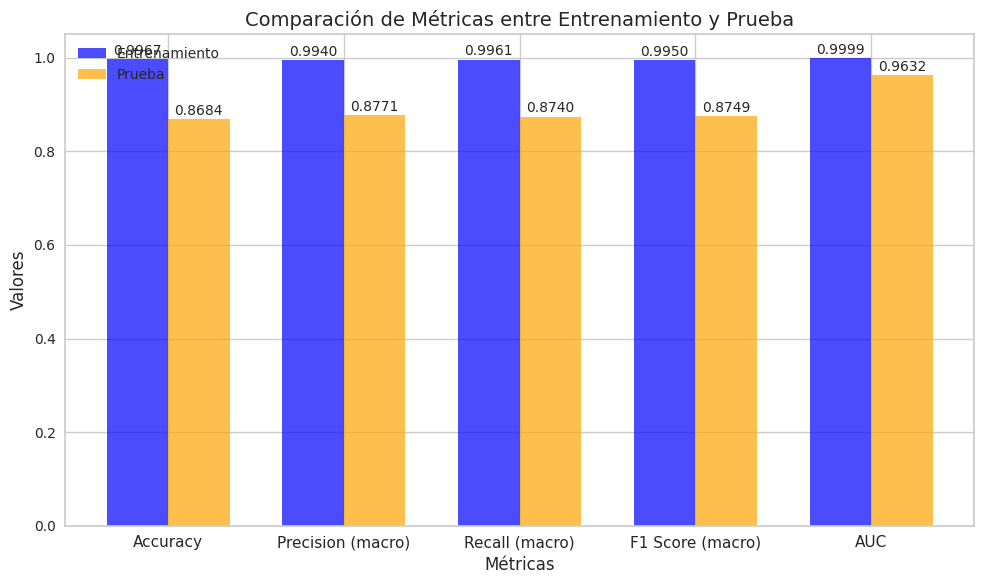

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de métricas para entrenamiento y prueba
metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 Score (macro)', 'AUC']
train_scores = [0.9967, 0.9940, 0.9961, 0.9950, 0.9999]  # Métricas del conjunto de entrenamiento
test_scores = [0.8684, 0.8771, 0.8740, 0.8749, 0.9632]  # Métricas del conjunto de prueba

# Crear la gráfica
x = np.arange(len(metrics))  # Posiciones en el eje X
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_scores, width, label='Entrenamiento', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, test_scores, width, label='Prueba', color='orange', alpha=0.7)

# Añadir etiquetas y título
ax.set_xlabel('Métricas', fontsize=12)
ax.set_ylabel('Valores', fontsize=12)
ax.set_title('Comparación de Métricas entre Entrenamiento y Prueba', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend()

# Mostrar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Mostrar gráfica
plt.tight_layout()
plt.show()


### 4.2

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


KeyboardInterrupt: 

### 5

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Dividir los datos en Train (60%), Validation (20%), y Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hiperparámetros a optimizar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'max_depth': [10, 20, None],     # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10], # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]    # Mínimo de muestras por hoja
}

# Configuración del Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',  # Métrica para optimizar
    cv=3,                # 3-fold cross-validation
    verbose=1,           # Mostrar progreso
    n_jobs=-1            # Usar todos los núcleos disponibles
)

# Optimización de hiperparámetros en el conjunto de entrenamiento
print("Optimización de hiperparámetros en curso...")
grid_search.fit(X_train, y_train)

# Mejor modelo y sus hiperparámetros
best_model = grid_search.best_estimator_
print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

In [ ]:
# Evaluar el mejor modelo en el conjunto de validación
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')

print("\nResultados en el conjunto de Validación (modelo optimizado):")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"ROC AUC: {val_auc:.4f}")
print(classification_report(y_val, y_val_pred))

In [ ]:

# Evaluar el mejor modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

In [ ]:
print("\nResultados en el conjunto de Prueba (modelo optimizado):")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"ROC AUC: {test_auc:.4f}")
print(classification_report(y_test, y_test_pred))

In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Supongamos que ya tienes un DataFrame llamado `df` con tus datos
# Asegúrate de que tu variable objetivo se llama 'target' y las demás son tus 13 variables

# Separar las características y la variable objetivo
X = X_resampled
y = y_resampled

# Convertir la variable objetivo a formato categórico (one-hot encoding)
ohe = OneHotEncoder(sparse_output=False)
y_encoded = ohe.fit_transform(y.values.reshape(-1, 1))

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Construir el modelo de red neuronal
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Capa de entrada
model.add(Dropout(0.3))  # Regularización
model.add(Dense(32, activation='relu'))  # Capa oculta
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # Capa de salida (3 clases)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con validación
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss en test: {loss:.4f}")
print(f"Accuracy en test: {accuracy:.4f}")

# Si deseas predecir con nuevos datos
# predictions = model.predict(nuevos_datos_escalados)


Epoch 1/50


I0000 00:00:1736713857.756196    9742 service.cc:145] XLA service 0x7fef28d40c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736713857.756231    9742 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-12 20:30:57.788523: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-12 20:30:57.848174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1736713857.947079    9742 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50981/50981 [==============================] - 122s 2ms/step - loss: 0.7332 - accuracy: 0.6580 - val_loss: 0.6792 - val_accuracy: 0.6836
Epoch 2/50
50981/50981 [==============================] - 113s 2ms/step - loss: 0.7002 - accuracy: 0.6761 - val_loss: 0.6701 - val_accuracy: 0.6883
Epoch 3/50
50981/50981 [==============================] - 113s 2ms/step - loss: 0.6954 - accuracy: 0.6784 - val_loss: 0.6684 - val_accuracy: 0.6907
Epoch 4/50
50981/50981 [==============================] - 113s 2ms/step - loss: 0.6932 - accuracy: 0.6799 - val_loss: 0.6656 - val_accuracy: 0.6922
Epoch 5/50
50981/50981 [==============================] - 113s 2ms/step - loss: 0.6906 - accuracy: 0.6810 - val_loss: 0.6617 - val_accuracy: 0.6950
Epoch 6/50
50981/50981 [==============================] - 113s 2ms/step - loss: 0.6867 - accuracy: 0.6831 - val_loss: 0.6539 - val_accuracy: 0.6976
Epoch 7/50
50981/50981 [==============================] - 114s 2ms/step - loss: 0.6848 - accuracy: 0.6837 - val_loss: 0.654

10925/10925 [==============================] - 10s 932us/step


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

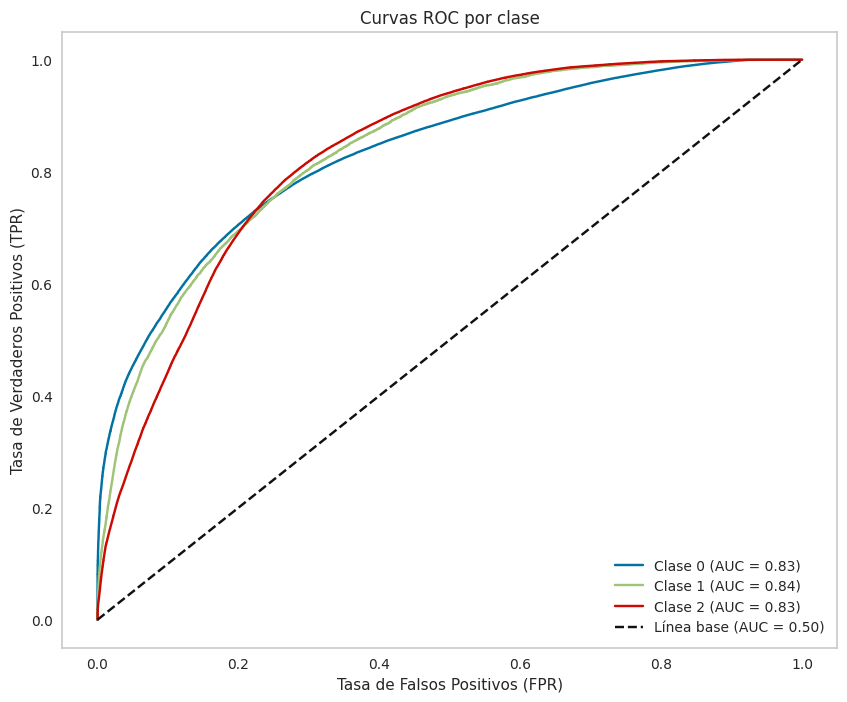

In [47]:
from sklearn.metrics import roc_curve, auc
# Obtener las probabilidades predichas
y_pred_prob = model.predict(X_test)

# Graficar la curva ROC para cada clase
fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Crear la gráfica
plt.figure(figsize=(10, 8))
for i in range(y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Línea base (AUC = 0.50)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right')
plt.grid()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

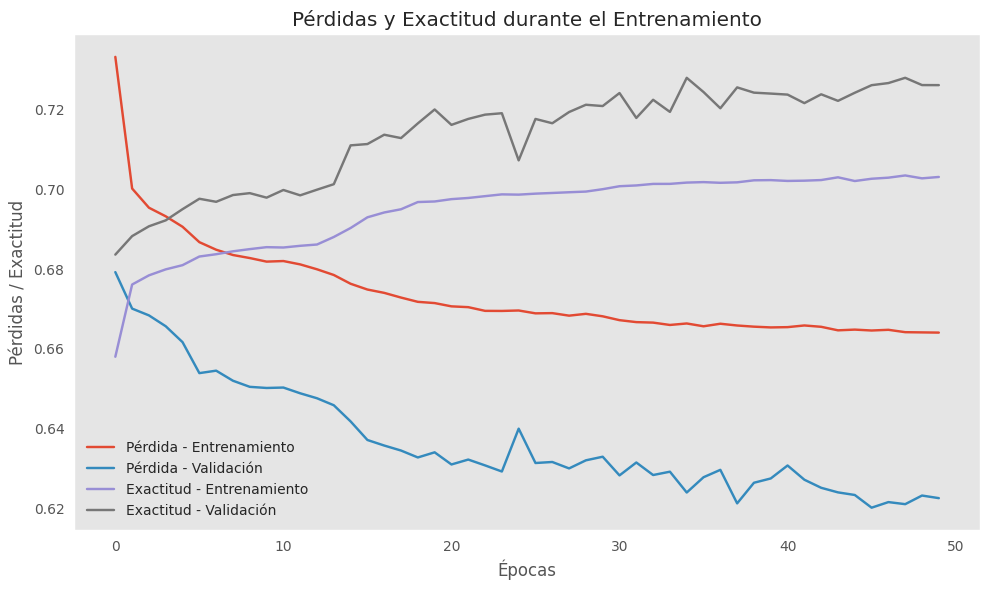

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Crear una gráfica de pérdidas (loss) y exactitud (accuracy) durante el entrenamiento
plt.style.use("ggplot")
plt.figure(figsize=(10, 6))

# Graficar las métricas de entrenamiento y validación
plt.plot(np.arange(0, len(history.history["loss"])), history.history["loss"], label="Pérdida - Entrenamiento")
plt.plot(np.arange(0, len(history.history["val_loss"])), history.history["val_loss"], label="Pérdida - Validación")
plt.plot(np.arange(0, len(history.history["accuracy"])), history.history["accuracy"], label="Exactitud - Entrenamiento")
plt.plot(np.arange(0, len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Exactitud - Validación")

# Personalizar el gráfico
plt.title("Pérdidas y Exactitud durante el Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdidas / Exactitud")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [53]:
from sklearn.metrics import classification_report
import numpy as np

# Realizar predicciones en el conjunto de prueba
y_pred_prob = model.predict(X_test)  # Probabilidades predichas
y_pred = np.argmax(y_pred_prob, axis=1)  # Convertir probabilidades en etiquetas

# Convertir y_test a etiquetas si está en formato one-hot encoding
y_test_labels = np.argmax(y_test, axis=1)

# Generar el classification report
report = classification_report(y_test_labels, y_pred, target_names=[f"Clase {i}" for i in range(y_test.shape[1])])
print(report)


10925/10925 [==============================] - 10s 938us/step
              precision    recall  f1-score   support

     Clase 0       0.77      0.81      0.79    199182
     Clase 1       0.71      0.08      0.14     22807
     Clase 2       0.66      0.71      0.68    127594

    accuracy                           0.72    349583
   macro avg       0.71      0.53      0.54    349583
weighted avg       0.72      0.72      0.71    349583



In [50]:
import boto3
from io import BytesIO
import tempfile

# Configurar cliente de S3
s3 = boto3.client('s3', region_name='us-east-1')

# Guardar el modelo en un archivo temporal
with tempfile.NamedTemporaryFile(suffix=".h5") as temp_file:
    model.save(temp_file.name)  # Guardar el modelo en formato HDF5
    temp_file.seek(0)  # Asegurar que el puntero esté al inicio del archivo
    
    # Leer el archivo temporal en un objeto BytesIO
    model_buffer = BytesIO(temp_file.read())

# Especificar nombre del bucket y objeto
bucket_name = 'evolucion-modelo-operativo'
object_name = 'modelos/NeuralNetworkModel.h5'

# Subir el modelo directamente a S3
try:
    s3.put_object(Bucket=bucket_name, Key=object_name, Body=model_buffer.getvalue())
    print(f"Modelo subido exitosamente a s3://{bucket_name}/{object_name}")
except Exception as e:
    print(f"Error al subir el modelo a S3: {e}")


Modelo subido exitosamente a s3://evolucion-modelo-operativo/modelos/NeuralNetworkModel.h5


In [51]:
with tempfile.NamedTemporaryFile(suffix=".h5") as temp_file:
    model.save(temp_file.name)  # El archivo temporal se crea y guarda aquí
    temp_file.seek(0)  # Nos aseguramos de leer desde el inicio del archivo

    # Leer el contenido del archivo temporal en un objeto BytesIO
    model_buffer = BytesIO(temp_file.read())
# Aquí el archivo temporal se elimina automáticamente

## Balanceo de clases ADASYN

In [31]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN(random_state=123).fit_resample(X, y)

In [32]:
y_resampled.value_counts()

3    1336056
2    1329134
1    1328677
Name: DestinoUsuario, dtype: int64

In [33]:
ada_dataset = X_resampled
ada_dataset['default'] = y_resampled
ada_dataset.shape

(3993867, 14)

### Modelo 7 Overfiting

In [34]:
model_7 = LGBMClassifier(random_state=42)
model_7.fit(X_resampled, y_resampled)

# Hacer predicciones y evaluar el modelo
y_pred = model_7.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.275087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 3993867, number of used features: 14
[LightGBM] [Info] Start training from score -1.100576
[LightGBM] [Info] Start training from score -1.100232
[LightGBM] [Info] Start training from score -1.095038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

## Balanced Random Forest Classifier

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=123)
brf.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = brf.predict(X_test)

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.72
              precision    recall  f1-score   support

           1       0.95      0.70      0.80    332230
           2       0.05      0.70      0.09      2454
           3       0.50      0.80      0.62     90755

    accuracy                           0.72    425439
   macro avg       0.50      0.73      0.50    425439
weighted avg       0.85      0.72      0.76    425439



## Balanceo SMOTEEN

In [7]:
from imblearn.combine import SMOTEENN

X = df_original[selected_features_2]
y = df_original['DestinoUsuario']

X_resampled, y_resampled = SMOTEENN(random_state=123).fit_resample(X, y)

In [8]:
X_resampled.to_csv('X_resampled.csv', index=False)
y_resampled.to_csv('y_resampled.csv', index=False)

In [30]:
X_resampled = pd.read_csv('X_resampled.csv')
y_resampled = pd.read_csv('y_resampled.csv')

In [9]:
y_resampled.value_counts()

2    1321308
3    1196438
1     942325
Name: DestinoUsuario, dtype: int64

In [10]:
smtn_dataset = X_resampled
smtn_dataset['default'] = y_resampled
smtn_dataset.shape

(3460071, 14)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
model_9 = RandomForestClassifier(random_state=42)
model_9.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model_9.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 1.00
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    188152
           2       1.00      1.00      1.00    264745
           3       1.00      1.00      1.00    239118

    accuracy                           1.00    692015
   macro avg       1.00      1.00      1.00    692015
weighted avg       1.00      1.00      1.00    692015



In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Predicciones y probabilidades en el conjunto de entrenamiento
y_train_pred = model_9.predict(X_train)
y_train_prob = model_9.predict_proba(X_train)

# Predicciones y probabilidades en el conjunto de prueba
y_test_pred = model_9.predict(X_test)
y_test_prob = model_9.predict_proba(X_test)


In [14]:

# Función para calcular métricas
def evaluate_model(y_true, y_pred, y_prob, dataset_name):
    print(f"Resultados en el conjunto de {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall (macro): {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"AUC (One-vs-Rest): {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 50)

# Evaluar en el conjunto de entrenamiento
evaluate_model(y_train, y_train_pred, y_train_prob, "entrenamiento")

# Evaluar en el conjunto de prueba
evaluate_model(y_test, y_test_pred, y_test_prob, "prueba")

Resultados en el conjunto de entrenamiento:
Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
F1 Score (macro): 1.0000
AUC (One-vs-Rest): 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    754173
           2       1.00      1.00      1.00   1056563
           3       1.00      1.00      1.00    957320

    accuracy                           1.00   2768056
   macro avg       1.00      1.00      1.00   2768056
weighted avg       1.00      1.00      1.00   2768056

--------------------------------------------------
Resultados en el conjunto de prueba:
Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
F1 Score (macro): 1.0000
AUC (One-vs-Rest): 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    188152
           2       1.00      1.00      1.00    264745
           3       1.00      1.00      1.00    239118

    accuracy                       

In [ ]:
import time
# Medir el tiempo de ejecución
start_time = time.time()  # Inicia el temporizador

# Suprimir advertencias generales
warnings.filterwarnings("ignore")

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_9, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para RandomForestClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model_10 = LGBMClassifier(random_state=42)
model_10.fit(X_resampled, y_resampled)

# Hacer predicciones y evaluar el modelo
y_pred = model_10.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 3460071, number of used features: 14
[LightGBM] [Info] Start training from score -1.300694
[LightGBM] [Info] Start training from score -0.962667
[LightGBM] [Info] Start training from score -1.061940
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [23]:
# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_10, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Promediar los puntajes
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Precisión en Entrenamiento')
plt.plot(train_sizes, test_scores_mean, label='Precisión en Prueba')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid()
plt.show()

In [21]:
model_11 = LGBMClassifier(reg_alpha=0.1, reg_lambda=0.1, max_depth=5, num_leaves=20, verbose=-1)
model_11.fit(X_resampled, y_resampled)

# Hacer predicciones y evaluar el modelo
y_pred = model_11.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 1.00
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    188152
           2       1.00      1.00      1.00    264745
           3       1.00      1.00      1.00    239118

    accuracy                           1.00    692015
   macro avg       1.00      1.00      1.00    692015
weighted avg       1.00      1.00      1.00    692015



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

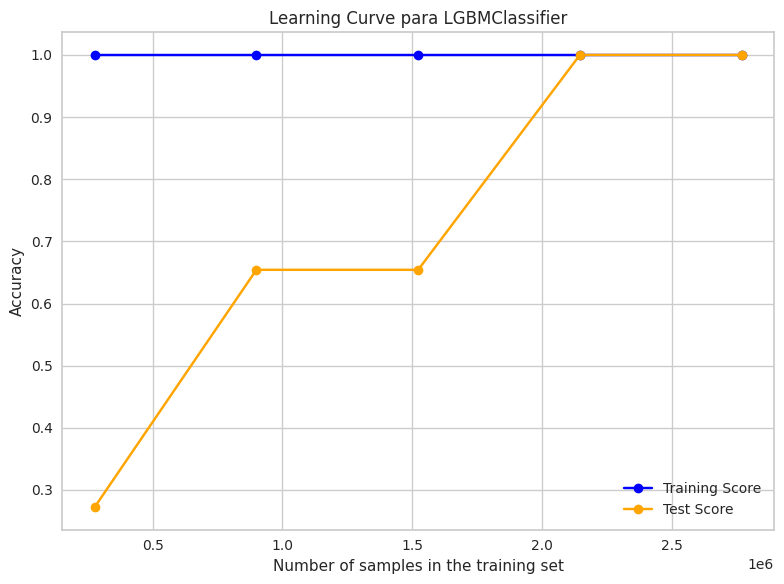

In [22]:
# Suprimir advertencias generales
warnings.filterwarnings("ignore")

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_11, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para LGBMClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

### Libreria pycaret

In [13]:
from pycaret.classification import *
clf = setup(data=ros_dataset, target = 'default', session_id=123)

In [14]:
model = create_model('lightgbm')

\
                                                 
Initiated  . . . . . . . . . . . . . . . . . .   
Status     . . . . . . . . . . . . . . . . . .   
Estimator  . . . . . . . . . . . . . . . . . .   

                                            
                                            
Initiated                         21:49:40  
Status                    Fitting 10 Folds  
Estimator  Light Gradient Boosting Machine

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Balanceo SMOTEEN 2

In [24]:
from imblearn.combine import SMOTEENN

X = df_original[selected_features_1]
y = df_original['DestinoUsuario']

In [11]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Crear el balanceador de sobremuestreo
oversampler = RandomOverSampler(sampling_strategy={2: 300000}, random_state=42)

# Ajustar y transformar los datos
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Verificar la nueva distribución de clases
print(f"Distribución de clases después del sobremuestreo aleatorio: {Counter(y_resampled)}")


Distribución de clases después del sobremuestreo aleatorio: Counter({1: 1328677, 3: 363105, 2: 300000})


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model_12 = LGBMClassifier(reg_alpha=0.1, reg_lambda=0.1, max_depth=5, num_leaves=20, verbose=-1)
model_12.fit(X_resampled, y_resampled)

# Hacer predicciones y evaluar el modelo
y_pred = model_12.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.77
              precision    recall  f1-score   support

           1       0.79      0.91      0.85    265890
           2       0.72      0.45      0.55     59833
           3       0.68      0.52      0.59     72634

    accuracy                           0.77    398357
   macro avg       0.73      0.63      0.66    398357
weighted avg       0.76      0.77      0.76    398357



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

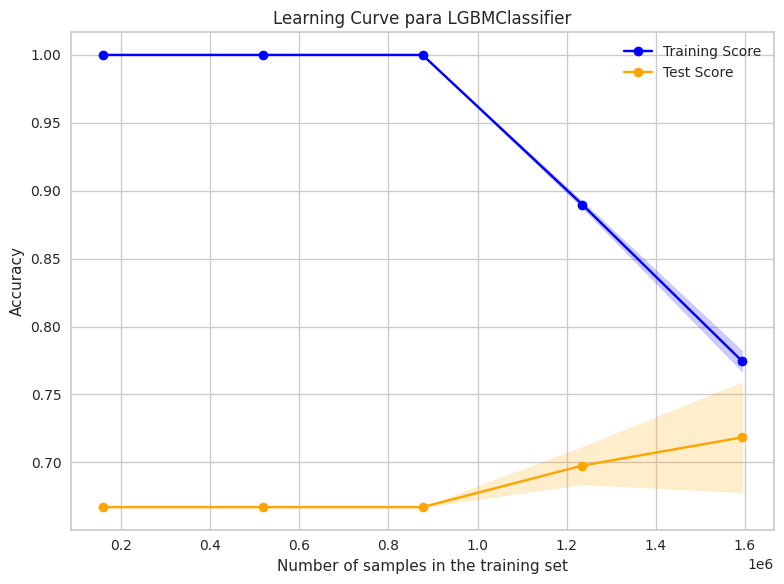

In [13]:
# Suprimir advertencias generales
warnings.filterwarnings("ignore")

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_12, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para LGBMClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

In [27]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Crear el balanceador de sobremuestreo
oversampler = RandomOverSampler(sampling_strategy={2: 300000}, random_state=42)

# Ajustar y transformar los datos
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Verificar la nueva distribución de clases
print(f"Distribución de clases después del sobremuestreo aleatorio: {Counter(y_resampled)}")

Distribución de clases después del sobremuestreo aleatorio: Counter({1: 1328677, 3: 363105, 2: 300000})


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model_12 = LGBMClassifier(reg_alpha=0.1, reg_lambda=0.1, max_depth=5, num_leaves=20, verbose=-1)
model_12.fit(X_resampled, y_resampled)

# Hacer predicciones y evaluar el modelo
y_pred = model_12.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.81
              precision    recall  f1-score   support

           1       0.83      0.93      0.88    265890
           2       0.77      0.53      0.63     59833
           3       0.75      0.62      0.68     72634

    accuracy                           0.81    398357
   macro avg       0.78      0.70      0.73    398357
weighted avg       0.81      0.81      0.80    398357



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

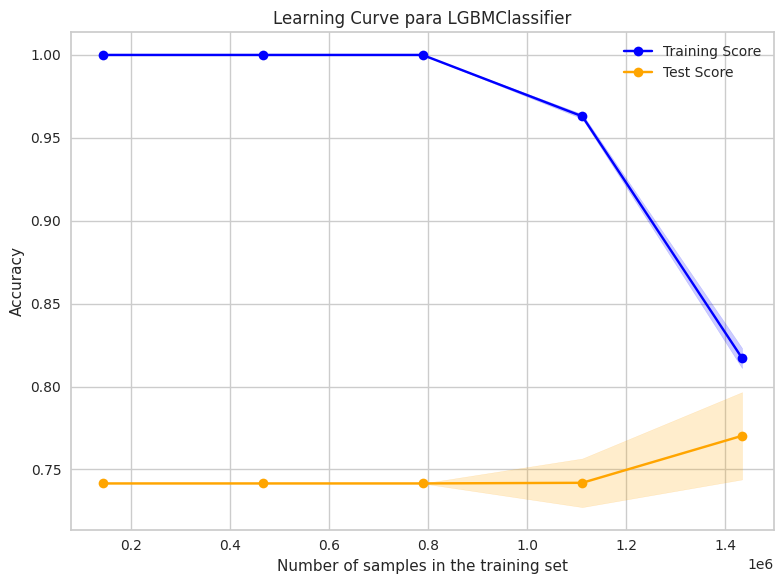

In [16]:
# Cambiar la configuración de la fuente predeterminada
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Suprimir advertencias generales
warnings.filterwarnings("ignore")

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_12, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para LGBMClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Entrenar el modelo
model_9 = RandomForestClassifier(random_state=42)
model_9.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred = model_9.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.92
              precision    recall  f1-score   support

           1       0.93      0.96      0.94    265890
           2       1.00      1.00      1.00     59833
           3       0.83      0.71      0.77     72634

    accuracy                           0.92    398357
   macro avg       0.92      0.89      0.90    398357
weighted avg       0.92      0.92      0.92    398357



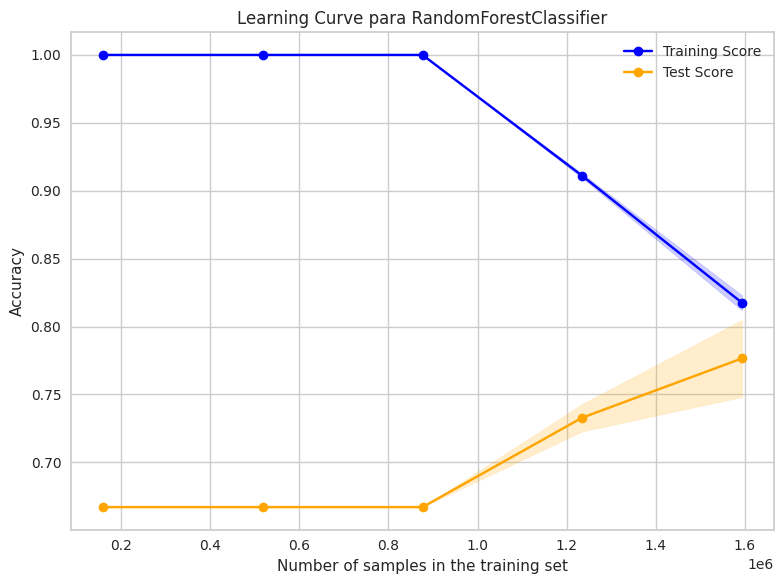

In [30]:
import matplotlib.pyplot as plt
import matplotlib
import warnings
from sklearn.model_selection import learning_curve
import numpy as np

# Cambiar la configuración de la fuente predeterminada
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# Suprimir advertencias generales
warnings.filterwarnings("ignore")

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_12, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para RandomForestClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Definir el modelo con los hiperparámetros ajustados
model_13 = RandomForestClassifier(random_state=42, max_depth=10, min_samples_split=10, n_estimators=100)

# Validación cruzada (cv=5)
cross_val_scores = cross_val_score(model_13, X_resampled, y_resampled, cv=5, scoring='accuracy')

# Imprimir resultados de validación cruzada
print(f"Precisión promedio en validación cruzada: {cross_val_scores.mean():.2f}")
print(f"Desviación estándar de la precisión: {cross_val_scores.std():.2f}")

# Entrenar el modelo con todo el conjunto de entrenamiento
model_13.fit(X_train, y_train)

# Hacer predicciones y evaluar en el conjunto de prueba
y_pred = model_13.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión en el conjunto de prueba: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Precisión promedio en validación cruzada: 0.76
Desviación estándar de la precisión: 0.03
Precisión en el conjunto de prueba: 0.78
              precision    recall  f1-score   support

           1       0.80      0.96      0.87    265178
           2       0.85      0.02      0.04     20379
           3       0.68      0.37      0.48     72800

    accuracy                           0.78    358357
   macro avg       0.77      0.45      0.46    358357
weighted avg       0.78      0.78      0.74    358357



In [22]:
# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_13, X_resampled, y_resampled, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Calcular promedios y desviaciones estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Crear la gráfica con los ajustes solicitados: quitar la cuadrícula y agregar puntos
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, test_mean, label="Test Score", color="orange", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")
plt.title("Learning Curve para RandomForestClassifier")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.tight_layout()  # Quitar cuadrícula ajustada automáticamente
plt.show()

KeyboardInterrupt: 